```
1. Recreate the model.
2. Add the weights
3. Split your image into equivalient parts
4. Apply phi on them
5. Pass them through the NN
6. Reconstruct the image via its parts
7. Apply BN3D denoiser
```

# THIS CELL PREDICTS LOCAL PATCHES

In [ ]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import utils

import io
import joblib
import image_slicer
import numpy as np
import scipy.ndimage as spimg
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image

np.random.seed(7)
%matplotlib inline

def get_data_patches(url_local, file):
    obj = spimg.imread(url_local + '/' + file, flatten=True, mode = 'L')
    print (obj.shape)
    tiles = image_slicer.main.slice(url_local + '/' + file, 4, save=False)
    for tile in tiles:
        print (tile)
        with io.BytesIO() as data:
            tile.save(data)
            tmp = data.getvalue()
            # print (tmp)

def get_data_patches_v2(url_datafolder, suburl_phi, suburl_testfolder, suburl_testimage):
    objs_original = []
    objs_phi = []
    
    with open(url_datafolder + suburl_phi, 'rb') as handle:
        phi = joblib.load(handle)
    print ('Phi:', phi, phi.shape)
    
    obj = spimg.imread(url_datafolder + suburl_testfolder + suburl_testimage, flatten=True, mode = 'L')
    plt.imshow(obj, cmap = plt.cm.gray)
    print ('Original Image:', obj.shape)
    obj_patches = image.extract_patches_2d(obj, (33, 33), max_patches=10)
    for obj_patch in obj_patches:
        objs_original.append(obj_patch)
        obj_patch_flatten = obj_patch.reshape((1, obj_patch.shape[0] * obj_patch.shape[1]))
        obj_patch_phi = (obj_patch_flatten * phi).reshape(33,33)
        objs_phi.append(obj_patch_phi)
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(obj_patch, cmap = plt.cm.gray)
        axarr[1].imshow(obj_patch_phi, cmap = plt.cm.gray)
    
    return objs_original, objs_phi

def model_disk(action, filename_model_arch, filename_model_weights, model=''):
    from keras.models import model_from_json
    
    print ('\n3. --------------------------------------> Model on Disk')
    if action == 'save':
        with open(filename_model_arch, "w") as handle:
            handle.write(model.to_json())
        model.save_weights(filename_model_weights)
        print("\nSaved model to disk")
        
    elif action == 'load':
        json_file = open(filename_model_arch, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.load_weights(filename_model_weights)
        print("Loaded model from disk")
    
    return model

if __name__ == "__main__":
    # get_data_patches('../data/original/SRCNN/Test/Set14/', 'baboon.bmp')
    # get_data_patches_v2('../data/','mr_70/data_phi.gz','original/SRCNN/Test/Set14/', 'lenna.bmp')
    objs_original, objs_phi = get_data_patches_v2('../data/','mr_70/data_phi.gz'
                                                      ,'original/SRCNN/Test/Set14/', 'monarch.bmp')
    
    model = model_disk('load', 'model/index_network_euclidean_keras_model.json'
                               , 'model/index_network_euclidean_keras_weights.h5'
                               , ''
                       )
    for i, obj_phi in enumerate(objs_phi):
        obj_predict = model.predict(obj_phi.reshape(1,1,33,33))
        print ('obj_predict:', obj_predict.shape)

        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(obj_phi.reshape(33,33), cmap = plt.cm.gray)
        axarr[1].imshow(objs_original[i].reshape(33,33), cmap = plt.cm.gray)
        axarr[2].imshow(obj_predict.reshape(33, 33), cmap = plt.cm.gray)
    

# THIS CELL PREDICTS LOCAL PATCHES AND STITCHES THEM TOGETHER 

1. Phi: [[1 1 0 ..., 0 0 0]] (1, 1089)

3. --------------------------------------> Model on Disk
Loaded model from disk
3. Original Image: (768, 512) RGB


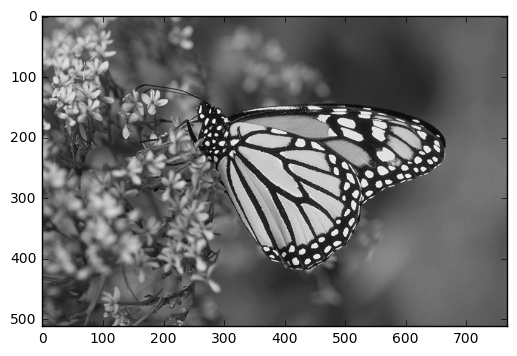

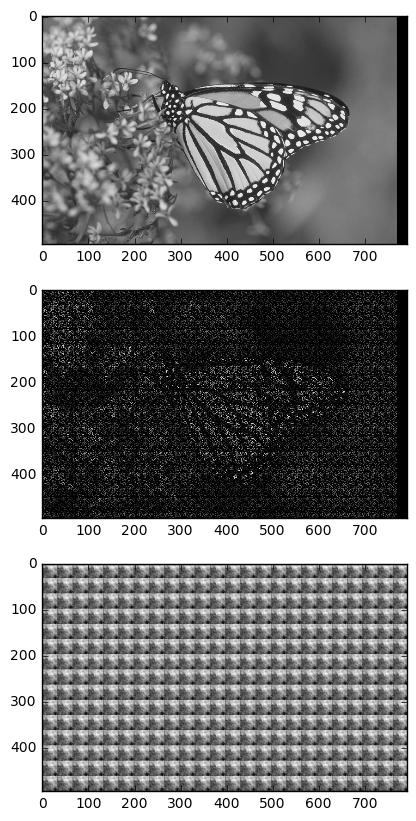

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import utils

import os
import PIL
import time
import joblib
import scipy.misc
import numpy as np
from PIL import Image
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

%matplotlib inline

def crop(Path, input, height, width, phi, model):
    im = Image.open(input)
    print ('3. Original Image:', im.size, im.mode)
    im = im.convert("L")
    
    im_numpy = np.array(im)
    plt.imshow(im_numpy, cmap = plt.cm.gray)
    
    im_array_orig = []
    im_array_phi = []
    im_array_pred = []
    
    im_array_orig_combined = []
    im_array_phi_combined = []
    im_array_pred_combined = []
    
    
    imgwidth, imgheight = im.size
    total_plots = len(range(0, imgheight, height))
    # f, axarr_orig = plt.subplots(total_plots-1,1)
    # f, axarr_pred = plt.subplots(total_plots-1,1)
    
    for row, i in enumerate(range(0, imgheight, height)):
        # print ('3. Row:', row, '/', total_plots)
        if row > 0:
            tmp_img_array_orig = np.array(im_array_orig)
            # print ('1. Row:',row-1, ' Image:', tmp_img_array.shape)
            tmp_img_array_orig = np.concatenate(tmp_img_array_orig, axis = 1)
            # axarr_orig[row-1].imshow(tmp_img_array_orig, cmap = plt.cm.gray)
            im_array_orig_combined.append(tmp_img_array_orig)

            tmp_img_array_phi = np.array(im_array_phi)
            tmp_img_array_phi = np.concatenate(tmp_img_array_phi, axis = 1)
            im_array_phi_combined.append(tmp_img_array_phi)

            tmp_img_array_pred = np.array(im_array_pred)
            tmp_img_array_pred = np.concatenate(tmp_img_array_pred, axis = 1)
            # axarr_pred[row-1].imshow(tmp_img_array_pred, cmap = plt.cm.gray)
            im_array_pred_combined.append(tmp_img_array_pred)

        im_array_orig = []
        im_array_phi = []
        im_array_pred = []

        for j in range(0, imgwidth, width):
            box = (j, i, j+width, i+height)  #(x1, y1, x2, y2) (0,0) <-- top-left corner
            im_cropped_tmp = np.array(im.crop(box))

            im_array_orig.append(im_cropped_tmp)
            img_phi_tmp = im_cropped_tmp.reshape(1, width * height) * phi
            im_array_phi.append(img_phi_tmp.reshape(width, height))
            im_array_pred_tmp = model.predict((img_phi_tmp).reshape(1,1, width, height))
            im_array_pred.append(im_array_pred_tmp.reshape(width, height))
    
    im_array_orig_combined = np.concatenate(im_array_orig_combined, axis = 0)
    im_array_pred_combined = np.concatenate(im_array_pred_combined, axis = 0)
    im_array_phi_combined = np.concatenate(im_array_phi_combined, axis = 0)
    
    return im_array_orig_combined, im_array_phi_combined, im_array_pred_combined

if __name__ == "__main__":
    # if (utils.check_gpu(verbose=0)):
    if 1:
        DATA_MR = 'mr20'
        MODEL_FOLDER = 'model_' + DATA_MR
        im_study = '../data/original/SRCNN/Test/Set14/monarch.bmp'
        # im_study = '../data/original/SRCNN/Test/Set14/baboon.bmp'
        
        TEST_FOLDER = MODEL_FOLDER + '/tests'
        if not(os.path.exists(TEST_FOLDER)):
            os.mkdir(TEST_FOLDER)
            
        url_datafolder = '../data/'
        suburl_phi = DATA_MR + '/data_phi.gz'
        with open(url_datafolder + suburl_phi, 'rb') as handle:
            phi = joblib.load(handle)
            print ('1. Phi:', phi, phi.shape)
        
        model = utils.model_disk('load', MODEL_FOLDER + '/index_network_euclidean_keras_model.json'
                               , MODEL_FOLDER + '/index_network_euclidean_keras_weights.h5'
                               , ''
                       )
                                    
        im_array_orig_combined, im_array_phi_combined, im_array_pred_combined,  = crop(
                                    '../method_euclidean/'
                                    , im_study
                                    , 33, 33, phi, model
                                )
        f, axarr = plt.subplots(3,1, figsize= (10,10))
        axarr[0].imshow(im_array_orig_combined, cmap = plt.cm.gray)
        axarr[1].imshow(im_array_phi_combined, cmap = plt.cm.gray)
        axarr[2].imshow(im_array_pred_combined, cmap = plt.cm.gray)
        
        im_name = im_study.split('/')[-1]
        im_dtype = '.' + im_name.split('.')[-1]
        im_name = im_name.split('.')[0]
        
        scipy.misc.imsave(TEST_FOLDER + '/' + im_name + im_dtype              , im_array_orig_combined)
        scipy.misc.imsave(TEST_FOLDER + '/' + im_name + '_phi' + im_dtype     , im_array_phi_combined)
        scipy.misc.imsave(TEST_FOLDER + '/' + im_name + '_reconnet' + im_dtype, im_array_pred_combined)
        
    else:
        print ('0. Oops! No GPU!!')

# THIS CELL CHECKS THE PEAK SNR FOR RECONNET IMAGE

In [2]:
from skimage.measure import compare_psnr

print ('Measured Image', compare_psnr((im_array_orig_combined).astype('float32')
                                           , im_array_phi_combined.astype('float32'), dynamic_range=255))

print ('Recovered Image', compare_psnr((im_array_orig_combined).astype('float32')
                                           , im_array_pred_combined, dynamic_range=255))

Measured Image 9.47641800698
Recovered Image 22.8809742287


# THIS CELL IS FOR EXPERIMENTATION